In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.linalg as la
import scipy.optimize as opt
from scipy.optimize import curve_fit
import pandas as pd
import xlrd
import typing
import sympy as sp
from sympy import symbols, Eq, solve


In [2]:
def correlationVV(t, A, B, C, D, E):
    y = ( (A*(np.exp(-B*t))) + (C*(np.exp(-(D)*t))) )**2 + E
    return y


In [3]:
def correlationVH(t, A, D, E):
    y = (A*(np.exp(-2*D*t))) + E
    return y


In [17]:
def relaxationrate(filenameVV, filenameVH, filetype, Angle):
    print(" ")
    print('Filenames:', filenameVV, 'and', filenameVH)
    
    if filetype == 'excel':
        dataVV = pd.read_excel(filenameVV)
        dataVH = pd.read_excel(filenameVH)
    if filetype == 'csv':
        dataVV = pd.read_csv(filenameVV, encoding= 'unicode_escape')
        dataVH = pd.read_csv(filenameVH, encoding= 'unicode_escape')
    
    xlabelVV = dataVV[dataVV.columns[0]][0]
    ylabelVV = dataVV[dataVV.columns[1]][0]
    xlabelVH = dataVH[dataVH.columns[0]][0]
    ylabelVH = dataVH[dataVH.columns[1]][0]
    
    TimeVV = dataVV[dataVV.columns[0]][1:201]
    CorrelationVV = dataVV[dataVV.columns[1]][1:201]
    TimeVH = dataVH[dataVH.columns[0]][1:201]
    CorrelationVH = dataVH[dataVH.columns[1]][1:201]
    
    xVV=[]
    yVV=[]
    xVH=[]
    yVH=[]
    
    xVV = np.array(list(map(float, TimeVV)))
    yVV = np.array(list(map(float, CorrelationVV)))
    xVH = np.array(list(map(float, TimeVH)))
    yVH = np.array(list(map(float, CorrelationVH)))
    
    parametersVV, covarianceVV = curve_fit(correlationVV, xVV, yVV, p0 = [0.1, 0.1, 0.1, 0.1, 0.1], bounds = (0, 10) )
    parametersVH, covarianceVH = curve_fit(correlationVH, xVH, yVH, p0 = [0.1, 0.1, 0.1], bounds = (0, 10) )
    
    best_A_VV = parametersVV[0]
    best_B_VV = parametersVV[1]
    best_C_VV = parametersVV[2]
    best_D_VV = parametersVV[3]
    best_E_VV = parametersVV[4]
    
    best_A_VH = parametersVH[0]
    best_D_VH = parametersVH[1]
    best_E_VH = parametersVH[2]
    
    #print("A:", best_A)
    print("")
    print("Translational Relaxation Rate for",Angle,"deg", best_B_VV, "1/microsec")
    print("Rotational+Translational Relaxation Rate (VV) for",Angle,"deg", best_D_VV, "1/microsec")
    print("Rotational+Translational Relaxation Rate (VH) for",Angle,"deg", best_D_VH, "1/microsec")
    
    if Angle == 60:
        Figure = 2
    if Angle == 75:
        Figure = 3
    if Angle == 90:
        Figure = 4
    if Angle == 105:
        Figure = 5
    if Angle == 120:
        Figure = 6
    
    fit_y_VV = correlationVV(xVV, best_A_VV, best_B_VV, best_C_VV, best_D_VV, best_E_VV)
    fit_y_VH = correlationVH(xVH, best_A_VH, best_D_VH, best_E_VH)
    
    plt.figure(Figure)
    plt.plot(xVV, yVV, 'o',markersize = 2, color = 'k')
    plt.plot(xVV, fit_y_VV, '-', label = Angle, color = 'k')
    plt.plot(xVH, yVH, 'o',markersize = 2, color = 'r')
    plt.plot(xVH, fit_y_VH, '-', label = Angle, color = 'r')
    plt.xscale('log')
    plt.xlabel(xlabelVV)
    plt.ylim([-0.03,0.5])
    plt.ylabel(ylabelVV)
    plt.title(filenameVV)
    plt.legend()

    #plt.savefig(filename,format='png') #saves over original file right now and kills it making it a png, don't uncomment for now
    
    return [best_B_VV, best_D_VV, best_D_VH]


In [18]:
def scatteringvec(RefractiveIndex, Angle): 
    
    RI = RefractiveIndex #Refractive Index of the sample
    wavelength = 637 # Units - nm, comes from the wavelength of the laser used in the DLS
    radian = (Angle*np.pi)/180
    
    q = ( 4*np.pi*(RI)*(np.sin(radian/2)) )/(wavelength) #Units 1/nm
    
    print(" ")
    print("Scattering Vector 'q' for",Angle, "deg:", q, "1/nm")
    
    return q


In [19]:
def diffusioncoef(sixtyVV, sixtyVH, seventyfiveVV ,seventyfiveVH ,nintyVV  ,nintyVH ,onehundredfiveVV ,onehundredfiveVH ,onehundredtwentyVV  ,onehundredtwentyVH , filetype, RefractiveIndex):
    
    q2 = np.zeros(5)
    q2[0] = scatteringvec(RefractiveIndex, 60)**2 #Units 1/nm
    q2[1] = scatteringvec(RefractiveIndex, 75)**2 #Units 1/nm
    q2[2] = scatteringvec(RefractiveIndex, 90)**2 #Units 1/nm
    q2[3] = scatteringvec(RefractiveIndex, 105)**2 #Units 1/nm
    q2[4] = scatteringvec(RefractiveIndex, 120)**2 #Units 1/nm
    
    B = np.zeros(5)
    DVV = np.zeros(5)
    DVH = np.zeros(5)
    
    B[0], DVV[0], DVH[0] = relaxationrate(sixtyVV, sixtyVH, filetype, 60) #Units - 1/microsec
    B[1], DVV[1], DVH[1] = relaxationrate(seventyfiveVV,seventyfiveVH, filetype, 75) #Units - 1/microsec
    B[2], DVV[2], DVH[2] = relaxationrate(nintyVV,nintyVH, filetype, 90) #Units - 1/microsec
    B[3], DVV[3], DVH[3] = relaxationrate(onehundredfiveVV,onehundredfiveVH, filetype, 105) #Units - 1/microsec
    B[4], DVV[4], DVH[4] = relaxationrate(onehundredtwentyVV,onehundredtwentyVH, filetype, 120) #Units - 1/microsec
    
    m, b = np.polyfit(q2, B, 1)
    
    plt.figure(1)
    plt.scatter(q2, B)
    plt.plot(q2, m*(q2)+b)
    
    
    plt.xlabel("Square Scattering Vector 'q^2' ")
    plt.ylabel("Relaxation Rate")
    plt.title("Translational Diffusion Coefficient")
    
    Dtr = m
    DrotVV = np.mean( np.subtract(DVV,B) )/6
    DrotVH = np.mean( np.subtract(DVH,B) )/6
    DrotAVG = np.mean( np.concatenate((np.subtract(DVV,B),np.subtract(DVH,B))) )/6
    
    print(" ")
    print(" ")
    print(" ")
    print("Translational Diffusion Coefficient 'Dtr':",Dtr, "nm^2 / microsec")
    print("Rotational Diffusion Coefficient VV 'DrotVV':",DrotVV, "nm^2 / microsec")
    print("Rotational Diffusion Coefficient VH 'DrotVH':",DrotVH, "nm^2 / microsec")
    print("Rotational Diffusion Coefficient Average 'DrotAVG':",DrotAVG, "nm^2 / microsec")
    print(" ")
    print(" ")
    
    return [Dtr, DrotVV, DrotVH, DrotAVG]


In [20]:
def LengthANDAspectRatio(sixtyVV, sixtyVH, seventyfiveVV ,seventyfiveVH ,nintyVV  ,nintyVH ,onehundredfiveVV ,onehundredfiveVH ,onehundredtwentyVV  ,onehundredtwentyVH , filetype, RefractiveIndex, Viscosity):
    
    kB = 1.380649*(1e-16) #Units - g*cm^2 / K*s^2
    T = 298.15 #Units - Kelvin, room temperature which should be the temperature of the sample
    Dtr = diffusioncoef(sixtyVV, sixtyVH, seventyfiveVV ,seventyfiveVH ,nintyVV  ,nintyVH ,onehundredfiveVV ,onehundredfiveVH ,onehundredtwentyVV  ,onehundredtwentyVH , filetype, RefractiveIndex)[0]*(1e-8) #Units - converting nm^2 / microsec to cm^2 / s
    Drot = diffusioncoef(sixtyVV, sixtyVH, seventyfiveVV ,seventyfiveVH ,nintyVV  ,nintyVH ,onehundredfiveVV ,onehundredfiveVH ,onehundredtwentyVV  ,onehundredtwentyVH , filetype, RefractiveIndex)[3]*(1e-8) #Units - converting nm^2 / microsec to cm^2 / s
    
    A, L = symbols('A L')
    
    #Going to approx ln to (x-1) - 0.5(x-1)^2 +.... etc.
    #F = Eq( -0.312 -(sp.ln(A)) -(0.565/A) +(0.1/(A**2)) + ((3*np.pi*Viscosity*Dtr)/(kB*T))*L*(1e7) , 0) #Units - converting cm to nm (depends a lot on units of viscosity)
    #G = Eq( 0.662 -(sp.ln(A)) -(0.917/A) +(0.05/(A**2)) + ((np.pi*Viscosity*Drot)/(3*kB*T))*(L**3)*(1e7) , 0 ) #Units - converting cm to nm (depends a lot on units of viscosity)
    #
    #sol_dict = solve((F,G), (A, L))
    #print(f'A = {sol_dict[A]}')
    #print(f'L = {sol_dict[L]}')

    return 

 
Scattering Vector 'q' for 60 deg: 0.013148329693046133 1/nm
 
Scattering Vector 'q' for 75 deg: 0.016008391946033117 1/nm
 
Scattering Vector 'q' for 90 deg: 0.018594546174458722 1/nm
 
Scattering Vector 'q' for 105 deg: 0.020862542562457162 1/nm
 
Scattering Vector 'q' for 120 deg: 0.022773575063022404 1/nm
 
Filenames: AuNR 750 400uL in DI Water Shutter 400 Angle 60 VV.csv and AuNR 750 400uL in DI Water Shutter 400 Angle 60 VH.csv

Translational Relaxation Rate for 60 deg 0.0009563845426560659 1/microsec
Rotational+Translational Relaxation Rate (VV) for 60 deg 0.0904502273693183 1/microsec
Rotational+Translational Relaxation Rate (VH) for 60 deg 0.03724616056949504 1/microsec
 
Filenames: AuNR 750 400uL in DI Water Shutter 400 Angle 75 VV.csv and AuNR 750 400uL in DI Water Shutter 400 Angle 75 VH.csv

Translational Relaxation Rate for 75 deg 0.08874256468751214 1/microsec
Rotational+Translational Relaxation Rate (VV) for 75 deg 0.08883503507707825 1/microsec
Rotational+Translationa

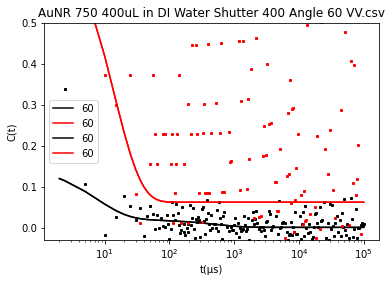

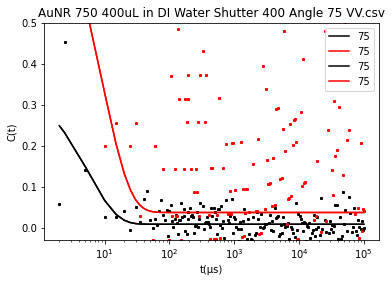

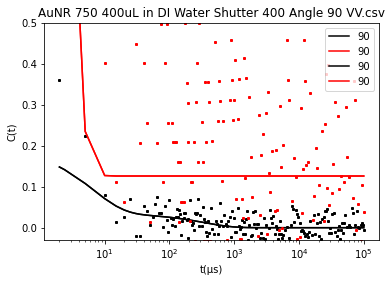

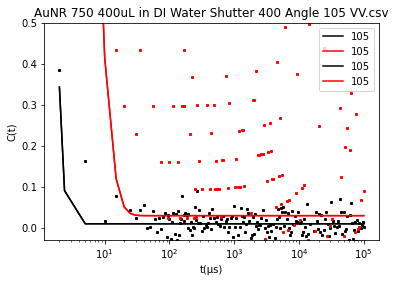

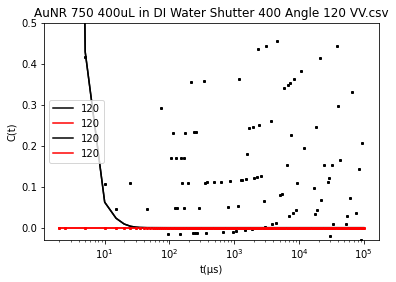

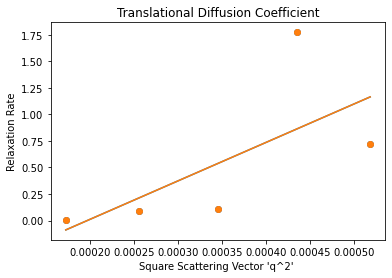

In [21]:
LengthANDAspectRatio(
    
    sixtyVV =  'AuNR 750 400uL in DI Water Shutter 400 Angle 60 VV.csv',
    sixtyVH =  'AuNR 750 400uL in DI Water Shutter 400 Angle 60 VH.csv',
    
    seventyfiveVV = 'AuNR 750 400uL in DI Water Shutter 400 Angle 75 VV.csv',
    seventyfiveVH = 'AuNR 750 400uL in DI Water Shutter 400 Angle 75 VH.csv',
    
    nintyVV = 'AuNR 750 400uL in DI Water Shutter 400 Angle 90 VV.csv',
    nintyVH = 'AuNR 750 400uL in DI Water Shutter 400 Angle 90 VH.csv',
    
    onehundredfiveVV = 'AuNR 750 400uL in DI Water Shutter 400 Angle 105 VV.csv',
    onehundredfiveVH = 'AuNR 750 400uL in DI Water Shutter 400 Angle 105 VH.csv',
    
    onehundredtwentyVV = 'AuNR 750 400uL in DI Water Shutter 400 Angle 120 VV.csv',
    onehundredtwentyVH = 'AuNR 750 400uL in DI Water Shutter 400 Angle 120 VH.csv',
         
    filetype = 'csv' ,
    #either 'excel' or 'csv'
         
    RefractiveIndex = 1.333 ,
    
    Viscosity = 0.008904
    #Viscosity in units g /cm*s (for all intents and purposes 100 mPa*s = 1 g /cm*s)
         
        )
